In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import glob
import os
from datetime import datetime
import seaborn as sns
import re

In [193]:
# data clean and merge
def str_to_num(x):
    try:
        hr = (int(x[3:5])*60 + int(x[6:]))/3600 + int(x[:2])
        return hr
    except:
        return np.nan
    
def fleet_data_load(directory):
    df = pd.read_excel(directory)
    df = df.dropna(subset=['Make', 'Model'], how = 'any')
    df = df.iloc[:, :-1]
    df['IMEI Unit'] = df['IMEI Unit'].astype('object')
    return df

def avl_data_load(directory):
    df = pd.read_csv(directory)
    df.columns = ['IMEI Unit', 'trip_start_time', 'trip_stop_time', 'distance_travelled', 'moving_time', 'idle_time', 'max_speed']
    df = df[~((df['idle_time'] == 0) & (df['moving_time'] == 0))] # remove rows with zero distance or moving time
    df['average_speed_with_idle'] = df['distance_travelled'] / (df['moving_time'] + df['idle_time']) * 3600
    df['average_speed_without_idle'] = (df['distance_travelled'] / df['moving_time'] * 3600).mask(df['moving_time'] == 0, 0)
    df['trip_start_year'] = df['trip_start_time'].apply(lambda x: int(str(x)[:4]))
    df['trip_stop_year'] = df['trip_stop_time'].apply(lambda x: int(str(x)[:4]))
    vehicle_start_year = pd.DataFrame(df.groupby('IMEI Unit')['trip_start_year'].min()).reset_index()
    vehicle_stop_year = pd.DataFrame(df.groupby('IMEI Unit')['trip_stop_year'].max()).reset_index()
    vehicle_start_year = vehicle_start_year.rename(columns = {'trip_start_year': 'avl_vehicle_start_year'})
    vehicle_stop_year = vehicle_stop_year.rename(columns = {'trip_stop_year': 'avl_vehicle_stop_year'})
    df = pd.merge(df, vehicle_start_year, on = 'IMEI Unit', how = 'left')
    df = pd.merge(df, vehicle_stop_year, on = 'IMEI Unit', how = 'left')
    cols = ['trip_start_time', 'trip_stop_time']
    for col in cols:
        del df[col]
    return df

def new_avl_data_load(directory):
    file_list = []
    for root, dirs, files in os.walk(directory):     
        for dir in dirs:
            files = glob.glob(os.path.join(root, dir, '*.xls'))
            for filename in files:
                if not filename.endswith('.xls'):
                    print(f"File not an Excel file: {filename}")
                    return pd.DataFrame()
                try:
                    df = pd.read_excel(filename)
                    file_list.append(df)   
                except Exception as e:
                    print(f"Error reading file: {filename}")
                
                if not file_list:
                    print(f"No files read from directory: {directory}")
                    return pd.DataFrame()

    df = pd.concat(file_list, axis=0, ignore_index=True)
    df = df.iloc[:, 1:10]
    df = df.rename(columns={'Asset': 'Vehicle Door No', 'Average Speed': 'average_speed_w_idle'})
    na_idx = df['Start Time'].isna() 
    df = df[~na_idx] # remove rows with empty start time
    df['average_speed_wo_idle'] = df['Distance Covered(KM)'] / df['Total Moving'].apply(str_to_num)
    df['Trip Start Year'] = df['Start Time'].dt.year.astype(int)
    df['Trip Stop Year'] = df['Stop Time'].dt.year.astype(int)
    vehicle_start_year = pd.DataFrame(df.groupby('Vehicle Door No')['Trip Start Year'].min()).reset_index()
    vehicle_stop_year = pd.DataFrame(df.groupby('Vehicle Door No')['Trip Stop Year'].max()).reset_index()
    vehicle_start_year = vehicle_start_year.rename(columns = {'Trip Start Year': 'new_avl_vehicle_start_year'})
    vehicle_stop_year = vehicle_stop_year.rename(columns = {'Trip Stop Year': 'new_avl_vehicle_stop_year'})
    df = pd.merge(df, vehicle_start_year, on = 'Vehicle Door No', how = 'left')
    df = pd.merge(df, vehicle_stop_year, on = 'Vehicle Door No', how = 'left')
    cols = ['Duration', 'Start Time', 'Stop Time']
    for col in cols:
        del df[col]
    return df

def data_merge(df1, df2, df3):
    df = pd.merge(df1, df2, on = 'IMEI Unit', how = 'left')
    # print(df['IMEI Unit'])
    merge_df = pd.merge(df, df3, on = 'Vehicle Door No', how = 'left')
    return merge_df

In [194]:
fleet_datapath = "../data/Aramco Leased Vehicles - from 2012 up-to-date.xlsx"
fleet_df = fleet_data_load(fleet_datapath)
fleet_df.head()

,Pri. Stat.,IMEI Unit,Vehicle Door No,Make,Model,Model Year,Activity Type,Activity Type Description,Actual Retired Date,Fuel Type,service_year
0,Retired,NaN,RT9971,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,5.0
1,Retired,NaN,RT9972,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,5.0
2,Retired,NaN,RT9973,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,5.0
3,Retired,NaN,RT9974,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,5.0
4,Retired,NaN,RT9975,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,5.0


In [195]:
avl_datapath = "../data/RND.csv"
avl_df = avl_data_load(avl_datapath)
avl_df.head()

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_12485/3148764382.py:17: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(directory)


,IMEI Unit,distance_travelled,moving_time,idle_time,max_speed,average_speed_with_idle,average_speed_without_idle,trip_start_year,trip_stop_year,avl_vehicle_start_year,avl_vehicle_stop_year
0,355200040542414,105.0,4999,418,104,69.780321,75.615123,2013,2013,2013,2019
1,355200040542414,218.0,10550,514,106,70.932755,74.388626,2013,2013,2013,2019
2,355200040542414,105.0,5181,747,104,63.765182,72.958888,2013,2013,2013,2019
3,355200040542414,184.0,8613,412,106,73.396122,76.907001,2013,2013,2013,2019
4,355200040542414,140.0,6031,102,120,82.178379,83.568231,2013,2013,2013,2019


In [196]:
avl_df['IMEI Unit'].nunique()

24829

In [197]:
new_avl_datapath = "../data/new_data"
new_avl_df = new_avl_data_load(new_avl_datapath)
new_avl_df.head()

,Vehicle Door No,Distance Covered(KM),Total Moving,Total Idle,Max Speed (KMPH),average_speed_w_idle,average_speed_wo_idle,Trip Start Year,Trip Stop Year,new_avl_vehicle_start_year,new_avl_vehicle_stop_year
0,DH0697,21.70,00:21:00,00:00:38,94.0,60.18,62.000000,2022,2022,2022,2023
1,DH0697,0.50,00:01:41,00:01:15,16.0,10.23,17.821782,2022,2022,2022,2023
2,DH0697,0.42,00:01:00,00:01:16,17.0,11.12,25.200000,2022,2022,2022,2023
3,DH0697,21.87,00:23:00,00:00:49,95.0,55.10,57.052174,2022,2022,2022,2023
4,DH0697,21.79,00:21:00,00:01:02,94.0,59.34,62.257143,2022,2022,2022,2023


In [204]:
new_avl_df[new_avl_df['Distance Covered(KM)']==0]

,Vehicle Door No,Distance Covered(KM),Total Moving,Total Idle,Max Speed (KMPH),average_speed_w_idle,average_speed_wo_idle,Trip Start Year,Trip Stop Year,new_avl_vehicle_start_year,new_avl_vehicle_stop_year
10,DH0697,0.0,00:00:00,00:41:50,0.0,0.0,NaN,2022,2022,2022,2023
11,DH0697,0.0,00:00:00,00:01:15,0.0,0.0,NaN,2022,2022,2022,2023
12,DH0697,0.0,00:00:00,00:15:27,0.0,0.0,NaN,2022,2022,2022,2023
46,DH0697,0.0,00:00:00,00:00:04,0.0,0.0,NaN,2022,2022,2022,2023
76,DH0697,0.0,00:00:00,00:05:21,0.0,0.0,NaN,2022,2022,2022,2023
...,...,...,...,...,...,...,...,...,...,...,...
988050,RT4440,0.0,00:00:00,00:00:15,0.0,0.0,NaN,2023,2023,2022,2023
988051,RT4440,0.0,00:00:00,00:00:48,0.0,0.0,NaN,2023,2023,2022,2023
988052,RT4440,0.0,00:00:00,00:16:14,0.0,0.0,NaN,2023,2023,2022,2023
988055,RT4440,0.0,00:00:00,00:00:31,0.0,0.0,NaN,2023,2023,2022,2023


In [198]:
merge_df = data_merge(fleet_df, avl_df, new_avl_df)
merge_df.head()

,Pri. Stat.,IMEI Unit,Vehicle Door No,Make,Model,Model Year,Activity Type,Activity Type Description,Actual Retired Date,Fuel Type,...,Distance Covered(KM),Total Moving,Total Idle,Max Speed (KMPH),average_speed_w_idle,average_speed_wo_idle,Trip Start Year,Trip Stop Year,new_avl_vehicle_start_year,new_avl_vehicle_stop_year
0,Retired,NaN,RT9971,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Retired,NaN,RT9972,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Retired,NaN,RT9973,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Retired,NaN,RT9974,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Retired,NaN,RT9975,Chevy,Tahoe,2008,TLPB2,Carryall 4x4,03/31/2013,Gasoline,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
print(fleet_df.shape, avl_df.shape, new_avl_df.shape, merge_df.shape)
print(merge_df.columns)
merge_df.shape
# save merged raw data, raw data is needed to calculate survival rate for retired vehicles
# merge_data_path = '../results/merged_data.csv'
# merge_df.to_csv(merge_data_path)

(25221, 11) (20226047, 11) (988086, 11) (4962133, 31)
Index(['Pri. Stat.', 'IMEI Unit', 'Vehicle Door No', 'Make', 'Model',
       'Model Year', 'Activity Type', 'Activity Type Description',
       'Actual Retired Date', 'Fuel Type', 'service_year',
       'distance_travelled', 'moving_time', 'idle_time', 'max_speed',
       'average_speed_with_idle', 'average_speed_without_idle',
       'trip_start_year', 'trip_stop_year', 'avl_vehicle_start_year',
       'avl_vehicle_stop_year', 'Distance Covered(KM)', 'Total Moving',
       'Total Idle', 'Max Speed (KMPH)', 'average_speed_w_idle',
       'average_speed_wo_idle', 'Trip Start Year', 'Trip Stop Year',
       'new_avl_vehicle_start_year', 'new_avl_vehicle_stop_year'],
      dtype='object')


(4962133, 31)

In [200]:
filtered_df = merge_df[~(merge_df['avl_vehicle_start_year'].isna() & merge_df['new_avl_vehicle_start_year'].isna())]

In [205]:
# based on results of num1 (number of overlapping vehicles between merge data and avl_df) and num2 (number of overlapping vehicles between merged data and new_avl_df),
# there are 40 vehicles in both avl and new_avl data files
num1 = np.isin(filtered_df['IMEI Unit'].unique(), avl_df['IMEI Unit'].unique()).sum()
num2 = np.isin(filtered_df['Vehicle Door No'].unique(), new_avl_df['Vehicle Door No'].unique()).sum()
print(num1, num2, num1+num2)
filtered_df['Vehicle Door No'].nunique()

5306 909 6215


6175

In [206]:
filtered_df['Activity Type Description'].nunique()

47

In [368]:
overlapping_vehicles = filtered_df[(filtered_df['avl_vehicle_start_year'].notna() & filtered_df['new_avl_vehicle_start_year'].notna())]
overlapping_vehicles['Vehicle Door No'].nunique()
filtered_df.head()

,Pri. Stat.,IMEI Unit,Vehicle Door No,Make,Model,Model Year,Activity Type,Activity Type Description,Actual Retired Date,Fuel Type,...,avl_vehicle_start_year,avl_vehicle_stop_year,Distance Covered(KM),Total Moving,Total Idle,Max Speed (KMPH),average_speed_w_idle,average_speed_wo_idle,new_avl_vehicle_start_year,new_avl_vehicle_stop_year
2721,Permanent,869395036647729.0,DH4610,Ford,Taurus,2021,TL003,Sedan Full-Size,NaN,Gasoline,...,NaN,NaN,0.31,00:01:00,00:01:21,49.0,7.91,18.60,2022.0,2023.0
2722,Permanent,869395036647729.0,DH4610,Ford,Taurus,2021,TL003,Sedan Full-Size,NaN,Gasoline,...,NaN,NaN,0.03,00:00:00,00:04:55,0.0,0.37,inf,2022.0,2023.0
2723,Permanent,869395036647729.0,DH4610,Ford,Taurus,2021,TL003,Sedan Full-Size,NaN,Gasoline,...,NaN,NaN,0.00,00:00:00,00:01:14,0.0,0.00,NaN,2022.0,2023.0
2724,Permanent,869395036647729.0,DH4610,Ford,Taurus,2021,TL003,Sedan Full-Size,NaN,Gasoline,...,NaN,NaN,0.00,00:00:00,00:00:55,0.0,0.00,NaN,2022.0,2023.0
2725,Permanent,869395036647729.0,DH4610,Ford,Taurus,2021,TL003,Sedan Full-Size,NaN,Gasoline,...,NaN,NaN,2.37,00:04:00,00:13:00,30.0,8.36,35.55,2022.0,2023.0


In [201]:
# Melt columns that represent the same statistics
def data_melt(df):
   df = df.rename(columns = {'distance_travelled': 'old_distance', 'Distance Covered(KM)': 'new_distance', 'moving_time': 'old_movingtime', 'Total Moving': 'new_movingtime', 'idle_time': 'old_idletime', 'Total Idle': 'new_idletime', \
                                               'max_speed': 'old_maxspeed', 'Max Speed (KMPH)': 'new_maxspeed', 'average_speed_with_idle':'old_averagespeedwithidle', 'average_speed_w_idle': 'new_averagespeedwithidle',\
                                               'average_speed_without_idle':'old_averagespeedwithoutidle', 'average_speed_wo_idle': 'new_averagespeedwithoutidle', 'trip_start_year': 'old_tripstartyear', 'Trip Start Year': 'new_tripstartyear',\
                                               'trip_stop_year': 'old_tripstopyear', 'Trip Stop Year': 'new_tripstopyear', 'avl_vehicle_start_year': 'old_avlvehiclestartyear', 'new_avl_vehicle_start_year': 'new_avlvehiclestartyear',\
                                                'avl_vehicle_stop_year': 'old_avlvehiclestopyear', 'new_avl_vehicle_stop_year': 'new_avlvehiclestopyear'})
   id_vars = ['Pri. Stat.','IMEI Unit','Vehicle Door No','Make','Model','Model Year','Activity Type','Activity Type Description','Actual Retired Date','Fuel Type','service_year']
   melt_cols = ['old_distance', 'new_distance', 'old_movingtime', 'new_movingtime', 'old_idletime', 'new_idletime', 'old_maxspeed', 'new_maxspeed', 'old_averagespeedwithidle', 'new_averagespeedwithidle', 'old_averagespeedwithoutidle', 'new_averagespeedwithoutidle',\
                'old_tripstartyear', 'new_tripstartyear', 'old_tripstopyear', 'new_tripstopyear', 'old_avlvehiclestartyear', 'new_avlvehiclestartyear', 'old_avlvehiclestopyear', 'new_avlvehiclestopyear']
   melt_df = pd.melt(df, id_vars = id_vars, value_vars = melt_cols, var_name='Statistics', value_name='Value')
   melt_df[['status', 'statistics_name']] = melt_df['Statistics'].str.split('_', n=1, expand=True)
   melt_df = melt_df.drop(columns = ['Statistics'])
   melt_df['Unique_Index'] = [i for i in range(1, len(df)*2+1)] * 10 
   final_df = melt_df.pivot(index=['Pri. Stat.','IMEI Unit','Vehicle Door No','Make','Model','Model Year','Activity Type','Activity Type Description','Actual Retired Date','Fuel Type','service_year','status', 'Unique_Index'], \
                            columns='statistics_name', values='Value').reset_index().drop('Unique_Index', axis=1)
   final_df = final_df.rename(columns = {'averagespeedwithidle': 'average_speed_with_idle', 'averagespeedwithoutidle': 'average_speed_without_idle', 'tripstartyear': 'trip_start_year', 'tripstopyear': 'trip_stop_year',\
                                         'avlvehiclestartyear': 'vehicle_start_year', 'avlvehiclestopyear': 'vehicle_stop_year', 'idletime': 'idle_time', 'movingtime': 'moving_time', 'maxspeed': 'max_speed'})
   return final_df



In [202]:
final_df = data_melt(filtered_df)
final_df.shape

(9886174, 22)

In [203]:
final_df.to_csv('../results/three_data_melt.csv')

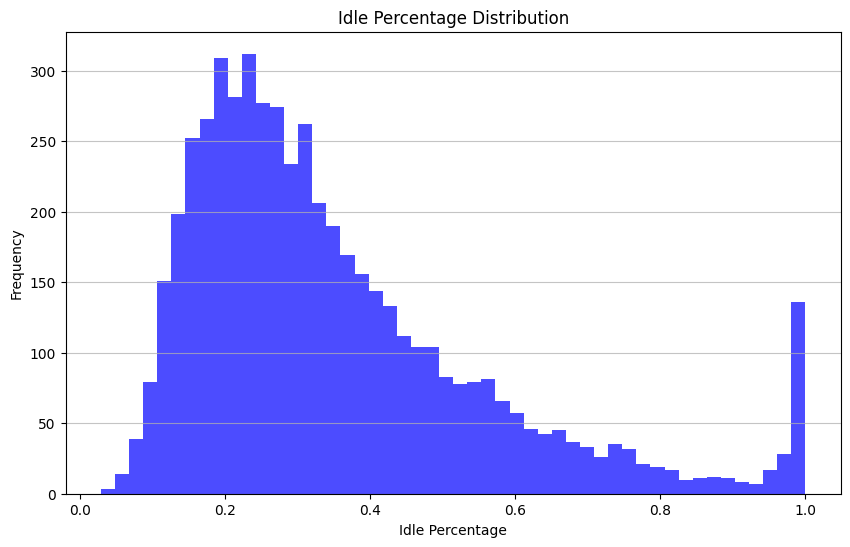

In [204]:
# plot idle perct distribution (each vehicle has one idle perct)
idle_sum = merge_df.groupby('Vehicle Door No')['idle_time'].sum()
moving_sum = merge_df.groupby('Vehicle Door No')['moving_time'].sum()
idle_perct = (idle_sum / (idle_sum + moving_sum)).reset_index()
idle_perct.columns = ['Vehicle Door No', 'idle_perct']

plt.figure(figsize=(10, 6))
plt.hist(idle_perct['idle_perct'], bins=50, color='blue', alpha=0.7)
plt.title('Idle Percentage Distribution')
plt.xlabel('Idle Percentage')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

In [2]:
# merged data analysis
final_df = pd.read_csv('../results/three_data_melt.csv')
print(final_df.shape, final_df.head())

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_12485/774025661.py:2: DtypeWarning: Columns (9,18,20) have mixed types. Specify dtype option on import or set low_memory=False.
  final_df = pd.read_csv('../results/three_data_melt.csv')


(9131998, 23)    Unnamed: 0 Pri. Stat.  IMEI Unit Vehicle Door No   Make      Model  \
0           0  Available        NaN          DH3242  Chevy  Silverado   
1           1  Available        NaN          DH3242  Chevy  Silverado   
2           2  Available        NaN          DH3242  Chevy  Silverado   
3           3  Available        NaN          DH3242  Chevy  Silverado   
4           4  Available        NaN          DH3242  Chevy  Silverado   

   Model Year Activity Type Activity Type Description Actual Retired Date  \
0        2018         TL027        Pickup 4x4 1/2 Ton                 NaN   
1        2018         TL027        Pickup 4x4 1/2 Ton                 NaN   
2        2018         TL027        Pickup 4x4 1/2 Ton                 NaN   
3        2018         TL027        Pickup 4x4 1/2 Ton                 NaN   
4        2018         TL027        Pickup 4x4 1/2 Ton                 NaN   

   ... average_speed_with_idle  average_speed_without_idle vehicle_start_year  \
0  

In [50]:
cols = ['average_speed_with_idle','average_speed_without_idle','vehicle_start_year','vehicle_stop_year','distance','idle_time','max_speed','moving_time','trip_start_year','trip_stop_year']
cleaned_df = final_df.dropna(subset=cols, how='all')
cleaned_df.shape

(7863191, 23)

In [51]:
conditions = np.isinf(cleaned_df['average_speed_without_idle']) | cleaned_df['average_speed_with_idle'].isna()
cleaned_df = cleaned_df.drop(cleaned_df[conditions].index)
cleaned_df = cleaned_df.dropna(subset=['average_speed_without_idle'])
cleaned_df = cleaned_df[cleaned_df['distance'] != 0]
speed_critical_value_1 = cleaned_df['average_speed_without_idle'].quantile(0.995) # .995 and .997 are determined based on the speed data to make sure speed is valid (not too large)
speed_critical_value_2 = cleaned_df['average_speed_with_idle'].quantile(0.997)
cleaned_df = cleaned_df[(cleaned_df['average_speed_without_idle'] < speed_critical_value_1) & (cleaned_df['average_speed_with_idle'] < speed_critical_value_2)]
print(cleaned_df.shape, cleaned_df[cleaned_df['distance'] == 0].shape, cleaned_df[cleaned_df['average_speed_without_idle'].isna()].shape)

(7045136, 23) (0, 23) (0, 23)


In [52]:
cleaned_df.to_csv('../results/cleaned_melt_data.csv')

In [53]:
cleaned_df['idle_time'] = cleaned_df['idle_time'].apply(str_to_num)
cleaned_df['moving_time'] = cleaned_df['moving_time'].apply(str_to_num)
print(cleaned_df.head(), cleaned_df.shape)

   Unnamed: 0 Pri. Stat.  IMEI Unit Vehicle Door No   Make      Model  \
1           1  Available        NaN          DH3242  Chevy  Silverado   
4           4  Available        NaN          DH3242  Chevy  Silverado   
5           5  Available        NaN          DH3242  Chevy  Silverado   
6           6  Available        NaN          DH3242  Chevy  Silverado   
8           8  Available        NaN          DH3242  Chevy  Silverado   

   Model Year Activity Type Activity Type Description Actual Retired Date  \
1        2018         TL027        Pickup 4x4 1/2 Ton                 NaN   
4        2018         TL027        Pickup 4x4 1/2 Ton                 NaN   
5        2018         TL027        Pickup 4x4 1/2 Ton                 NaN   
6        2018         TL027        Pickup 4x4 1/2 Ton                 NaN   
8        2018         TL027        Pickup 4x4 1/2 Ton                 NaN   

   ... average_speed_with_idle  average_speed_without_idle vehicle_start_year  \
1  ...           

In [189]:
#### Visualization
def vehicle_model_year_dist(df):
    model_years = df['Model Year'].unique()
    num_vehicle_per_model_year = [[df[df['Model Year'] == year]['Vehicle Door No'].nunique(), year] for year in model_years]

    plt.figure(figsize=(10, 6))
    x_values = [arr[1] for arr in num_vehicle_per_model_year]  # First elements for x-axis
    y_values = [arr[0] for arr in num_vehicle_per_model_year]  # Second elements for y-axis
    plt.bar(x_values, y_values, color='skyblue', edgecolor='black')
    plt.xticks(x_values)
    plt.xlabel('Model Year')
    plt.ylabel('Number of Vehicles')
    plt.title('Number of Vehicles per Model Year')

def vehicle_vkt_record_year(df, record_year):
    num_vehicle_per_record_year = df.groupby(record_year)['Vehicle Door No'].nunique()
    plt.figure(figsize=(10, 6))
    plt.bar(num_vehicle_per_record_year.index, num_vehicle_per_record_year.values, color='skyblue', edgecolor='black')
    plt.xlabel(record_year)        
    plt.ylabel('Number of Vehicles')
    plt.xticks(num_vehicle_per_record_year.index)

def speed_dist(df):
    bins = 20
    fig, ax = plt.subplots()
    sns.histplot(df['average_speed_without_idle'], stat='percent', bins = bins, kde=True)
    sns.histplot(df['average_speed_with_idle'], stat='percent', bins = bins,  kde = True)
    plt.legend([ 'Average speed without idle', 'Average speed with idle'])
    plt.xlabel('Speed (km/h)')
    plt.ylabel('Percentage')
    plt.title('Speed distribution')

def distance_speed_dist(df, which_speed):
    
    def get_minimum_divisible_by_10(value):
        """
        Returns the smallest integer that is divisible by 10 and greater than or equal to the given value.
        """
        if value % 10 == 0:
            return int(value)
        else:
            return int((value // 10 + 1) * 10)
    

    def get_percentage_for_speed(df, whichspeed, critical_speed):
        df["Upper_Bound"] = df[whichspeed].apply(lambda x: int(re.search(r'(\d+)]', x).group(1)))
        result = df.loc[df["Upper_Bound"] == critical_speed, "cumulative_dist_percent"]
        return int(result.values[0]) if not result.empty else None


    max_speed = df[which_speed].max()
    min__divisible_by_10 = get_minimum_divisible_by_10(max_speed)
    bins = list(range(0, min__divisible_by_10, 10))
    distance_by_speed_range = df.groupby(pd.cut(df[which_speed], bins))[['distance']].sum()
    distance_by_speed_range['cumulative_distance'] = distance_by_speed_range['distance'].cumsum()
    distance_by_speed_range['cumulative_dist_percent'] = distance_by_speed_range['cumulative_distance'] / distance_by_speed_range['distance'].sum() * 100
    distance_by_speed_range = distance_by_speed_range.reset_index()
    distance_by_speed_range[which_speed] = distance_by_speed_range[which_speed].astype(str)

    # calculate the cumulative distance percentage at 80km/h, 80km/h is assumed to be the critical speed that divides city and hwy driving
    critical_value = 80
    perct_80 = get_percentage_for_speed(distance_by_speed_range, which_speed, critical_value)
    
    fig1, ax = plt.subplots(figsize=(10, 6))
    plt.bar(distance_by_speed_range[which_speed], distance_by_speed_range['distance'], color='skyblue', edgecolor='black')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(which_speed)
    plt.ylabel('Distance (km)')
    plt.title('Distance by Speed Range')

    fig2,ax1 = plt.subplots(figsize=(10, 6))
    plt.plot(distance_by_speed_range[which_speed], distance_by_speed_range['cumulative_distance'], color='red', marker='o')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(which_speed)
    plt.ylabel('Cumulative Distance (km)')
    plt.title('Cumulative Distance by Speed Range')

    fig3,ax2 = plt.subplots(figsize=(10, 6))
    plt.plot(distance_by_speed_range[which_speed], distance_by_speed_range['cumulative_dist_percent'], color='green', marker='+')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel(which_speed)
    plt.ylabel('Cumulative Distance Percentage')
    plt.title('Cumulative Distance Percentage by Speed Range') 
    target_x = '(70, 80]'
    target_y = perct_80 
    ax2.plot(target_x, target_y, 'ro')
    ax2.annotate(f'({critical_value}, {perct_80}%)', (target_x, target_y), textcoords="offset points", xytext=(0,10), ha='center')

    print(f"The cumulative distance percentage at {critical_value} km/h is {perct_80}")
    


/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_12485/230479647.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_by_speed_range = df.groupby(pd.cut(df[which_speed], bins))[['distance']].sum()


The cumulative distance percentage at 80 km/h is 48


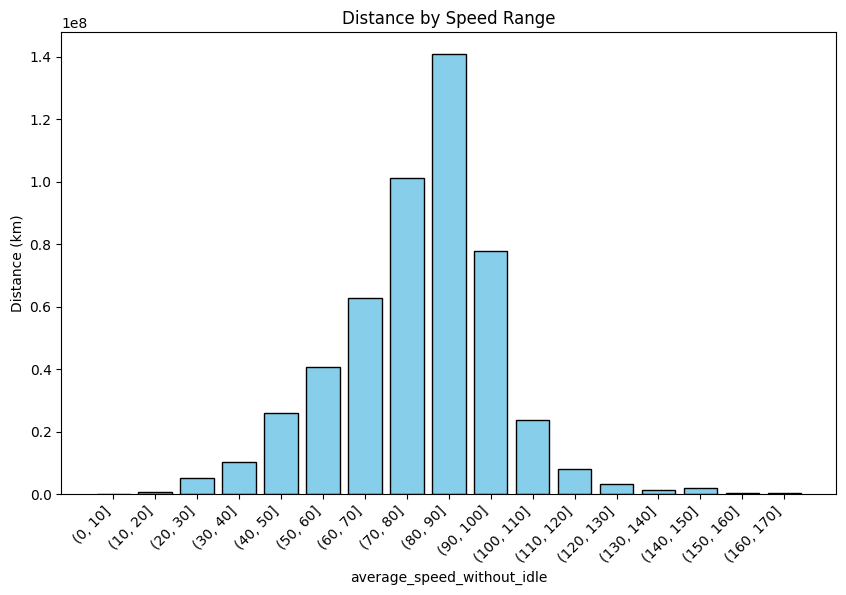

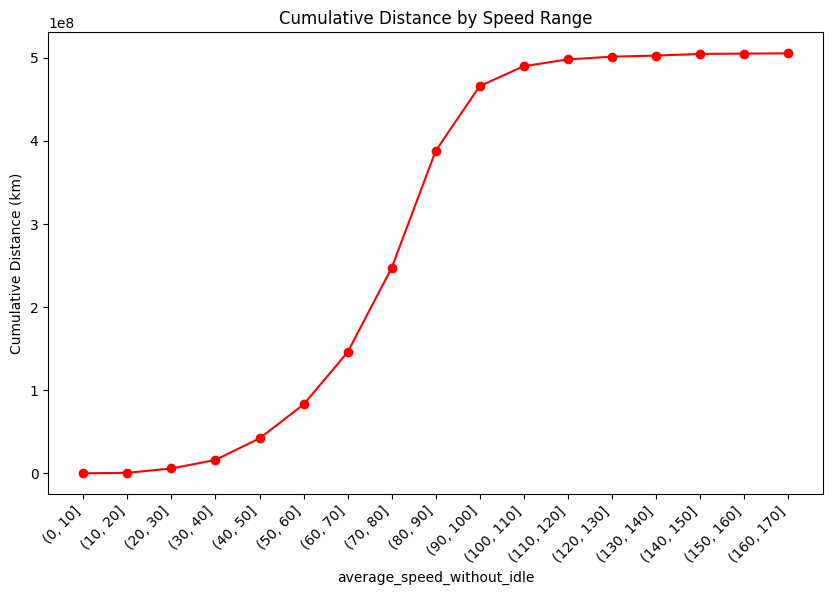

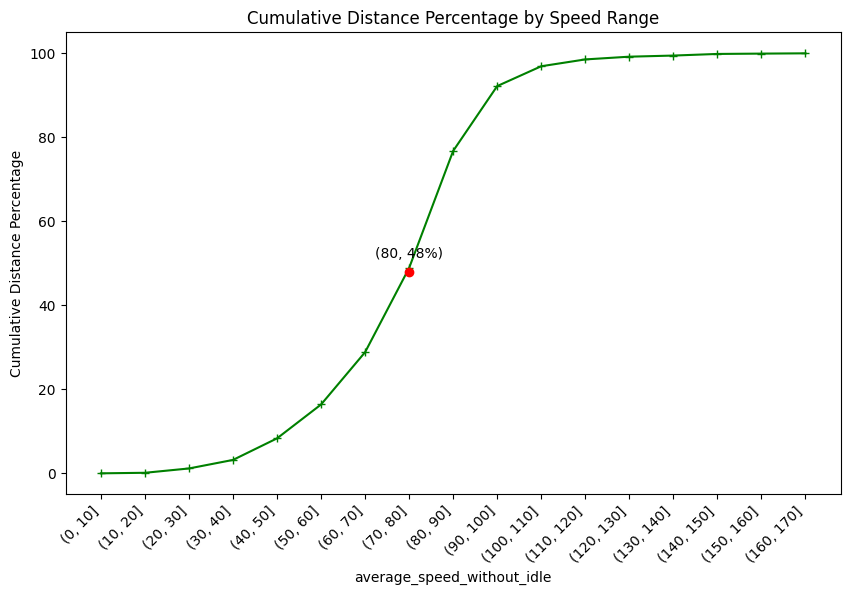

In [190]:
distance_speed_dist(cleaned_df, 'average_speed_without_idle')

/var/folders/rh/5tkty3715h119sm4y35zw4dr0000gn/T/ipykernel_12485/230479647.py:54: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  distance_by_speed_range = df.groupby(pd.cut(df[which_speed], bins))[['distance']].sum()


The cumulative distance percentage at 80 km/h is 76


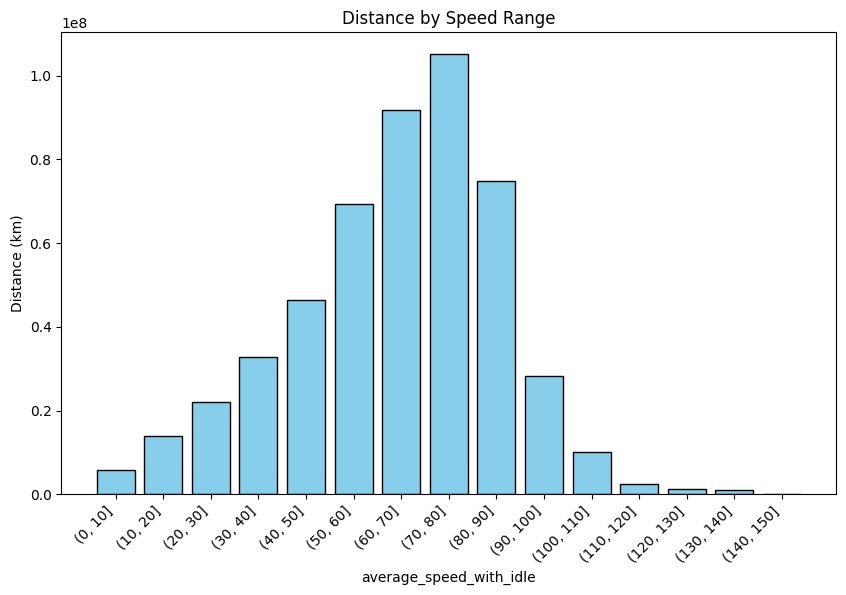

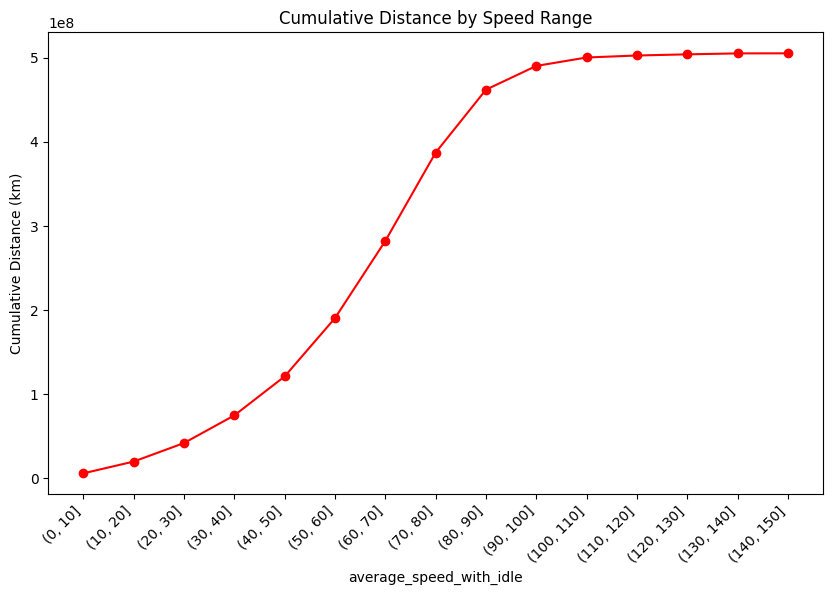

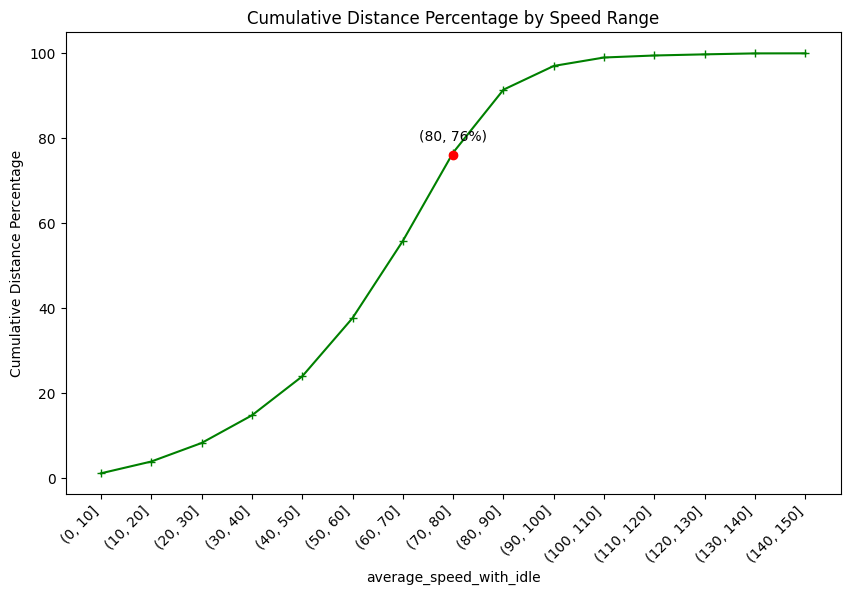

In [191]:
distance_speed_dist(cleaned_df, 'average_speed_with_idle')

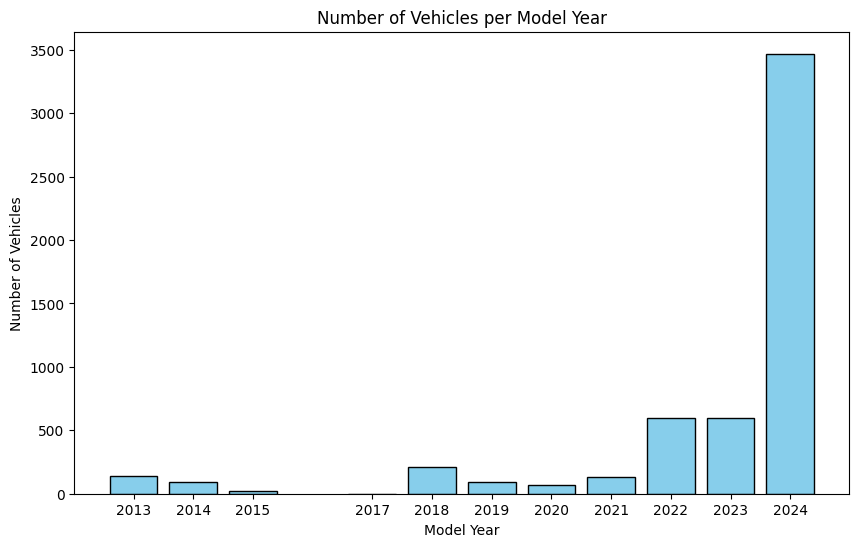

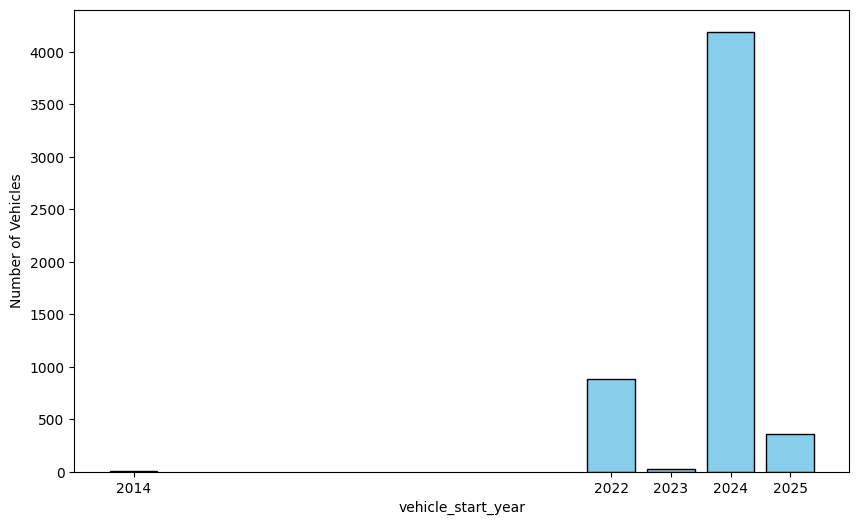

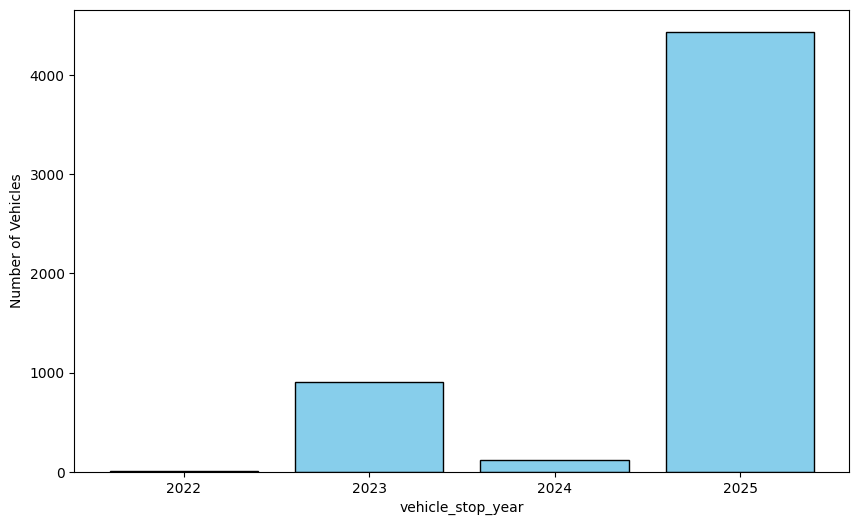

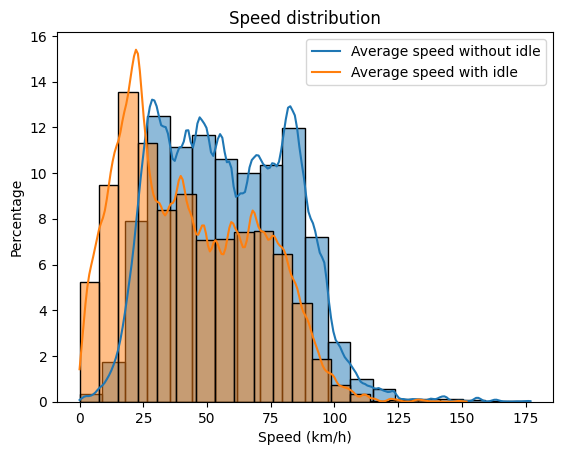

In [62]:
vehicle_model_year_dist(cleaned_df)
vehicle_vkt_record_year(cleaned_df, 'vehicle_start_year')
vehicle_vkt_record_year(cleaned_df, 'vehicle_stop_year')
speed_dist(cleaned_df)

In [63]:
cleaned_df['Vehicle Door No'].nunique()

5425

In [69]:
cleaned_df['average_speed_without_idle'].max()

np.float64(176.92193308550188)